https://www.youtube.com/watch?v=V1bF37-_ytQ
Gaussian Processes Practical Demonstration

In [2]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processess libary
import GPy
from IPython.display import display

### Understanding the GPR RBF Kernel

In [2]:
# Create a 1-0 RBF kernel with default parammeters
k = GPy.kern.RBF(1)
# Preview the kernel's parameters
k.variance

index,rbf.variance,constraints,priors
[0],1.00000000,+ve,


In [3]:
# OUr sample space: 100 samples in the interval [-4,4]
X = np.linspace(-4,4,100)[:, None] # we need [:, None] to reshape X into a column vector for use in Gaussian

# First, sample kernel at x' = 0
K = k.K(X, np.array([[0.]])) # k(x,0)

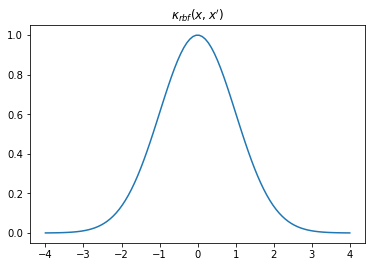

In [4]:
plt.plot(X, K)
plt.title("$\kappa_{rbf}(x,x')$");

In [5]:
fig, ax = plt.subplots()
from matplotlib.animation import FuncAnimation
from matplotlib import rc
ls = [0.05, 0.25, 0.5, 1., 2., 4.]

def update(iteration):
    ax.cla()
    k = GPy.kern.RBF(1)
    k.lengthscale = ls[iteration]
    # Calculate the new covariance function at k(x,0)
    C = k.K(X, np.array([[0.]]))
    # Plot the resulting covariance vector
    ax.plot(X,C)
    ax.set_title("$\kappa_{rbf}(x,x')$\nLength scale = %s" %k.lengthscale[0]);
    ax.set_ylim((0, 1.2))

num_iterations = len(ls)
anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations-1, 1), interval=500)
plt.close()

rc('animation', html='jshtml')
anim

In [6]:
fig, ax = plt.subplots()
import os
from matplotlib.animation import FuncAnimation
from matplotlib import rc
variances = [0.01, 0.05, 0.25, 0.5, 1., 2., 4.]

def update(iteration):
    ax.cla()
    k = GPy.kern.RBF(1)
    k.variance = variances[iteration]
    # Calculate the new covariance function at k(x,0)
    C = k.K(X, np.array([[0.]]))
    # Plot the resulting covariance vector
    ax.plot(X,C)
    ax.set_title("$\kappa_{rbf}(x,x')$\nVariance = %s" %k.variance[0]);
    ax.set_ylim((0,2))

num_iterations = len(ls)
anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations-1, 1), interval=500)
plt.close()

rc('animation', html='jshtml')
anim

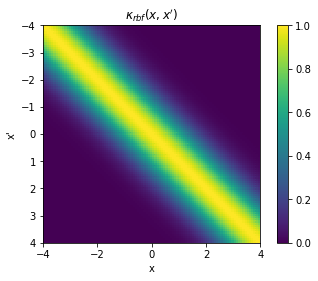

In [7]:
x = np.linspace(-4.,4.,30)[:, None]
K = k.K(X,X)

# Plot the covariance of the sample space
plt.pcolor(X.T, X, K)

# Format and annotate plot
plt.gca().invert_yaxis(), plt.gca().axis("image")
plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
plt.title("$\kappa_{rbf}(x,x')$");

In [8]:
fig, ax = plt.subplots()
cax = fig.add_axes([0.87, 0.2, 0.05, 0.65])

def update(iteration):
    ax.cla()
    cax.cla()
    k = GPy.kern.RBF(1)
    k.lengthscale = ls[iteration]
    # Calculate the new covariance function at k(x,0)
    K = k.K(X,X)

    #Plot the covariance of the sample space
    im = ax.pcolor(X.T, X, K)

    # Format and annotate plot
    ax.invert_yaxis()
    ax.axis("image")
    #ax.colorbar()
    # Plot the resulting covariance vector
    ax.set_title("Length scale = %s" %k.lengthscale[0]);
    #ax.set_ylim((0, 1.2))
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.tight_layout()

num_iterations = len(ls)
anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations, 1), interval=500)
plt.close()

rc('animation', html='jshtml')
anim

In [9]:
fig, ax = plt.subplots()
cax = fig.add_axes([0.87, 0.2, 0.05, 0.65])

def update(iteration):
    ax.cla()
    cax.cla()
    k = GPy.kern.RBF(1)
    k.variance = variances[iteration]
    # Calculate the new covariance function at k(x,0)
    K = k.K(X,X)

    #Plot the covariance of the sample space
    im = ax.pcolor(X.T, X, K)

    # Format and annotate plot
    ax.invert_yaxis()
    ax.axis("image")
    #ax.colorbar()
    # Plot the resulting covariance vector
    ax.set_title("Variance = %s" %k.variance[0]);
    #ax.set_ylim((0, 1.2))
    fig.colorbar(im, cax=cax, orientation='vertical')
    fig.tight_layout()

num_iterations = len(ls)
anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations, 1), interval=500)
plt.close()

rc('animation', html='jshtml')
anim

### GP Regression

Creating a data set

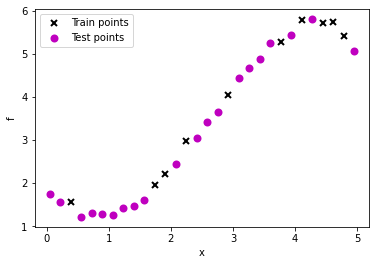

In [31]:
# lambda function, call f(x) to generate data
f = lambda x: 0.4*x**2 - 0.15*x**3 + 0.5*x**2 - 0.002*x**5 + 0.0002*x**6 +0.5*(x-2)**2

np.random.seed(0)
# 30 equally spaced sample locations
X = np.linspace(0.05, 4.95, 30)[:,None]

np.random.shuffle(X)

# y = f(X) + epsilon
Y = f(X) + np.random.normal(0., 0.1, (30,1)) # note that np.random.normal takes mean s.d. (not variance),

train_X = X[:10]
train_Y = Y[:10]

test_X = X[10:]
test_Y = Y[10:]

# Plot observations
plt.plot(train_X, train_Y, "kx", mew=2, label='Train points')
plt.plot(test_X, test_Y, "mo", mew=2, label='Test points')

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend()

### Fitting the above data using GPR with RBF kernel by varying the length scale (Noiseless case)

Here we assume that observations (train instances) are noise free. Thus, the GP fit must pass exactly through the train points

In [39]:
fig, ax = plt.subplots()

ls = [0.05, 0.25, 0.5, 1., 2., 4.]
from sklearn.metrics import mean_absolute_error

def update(iteration):
    ax.cla()
    k = GPy.kern.RBF(1)
    k.lengthscale = ls[iteration]
    m = GPy.models.GPRegression(train_X, train_Y, k)
    m.Gaussian_noise = 0.0
    m.plot(ax=ax)
    ax.plot(test_X, test_Y, "mo", mew=2, label='Test points')

    ax.legend()
    ax.set_title("Length scale = %s, MAE = %s" %(k.lengthscale[0], mean_absolute_error(test_Y, m.predict(test_X)[0].flatten())))
    fig.tight_layout()

num_iterations = len(ls)
anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations, 1), interval=500)
plt.close()

rc('animation', html='jshtml')
anim

### Fitting the above data using GPR with RBF kernel by varying the length scale (Noisy case)

Here we assume that observations (train instances) have noise. Thus, the GP fit may not pass exact train points

In [42]:
fig, ax = plt.subplots()

ls = [0.05, 0.25, 0.5, 1., 2., 4.]
from sklearn.metrics import mean_absolute_error

def update(iteration):
    ax.cla()
    k = GPy.kern.RBF(1)
    k.lengthscale = ls[iteration]
    m = GPy.models.GPRegression(train_X, train_Y, k)
    m.plot(ax=ax)
    ax.plot(test_X, test_Y, "mo", mew=2, label='Test points')

    ax.legend()
    ax.set_title("Length scale = %s, MAE = %s" %(k.lengthscale[0], mean_absolute_error(test_Y, m.predict(test_X)[0].flatten())))
    fig.tight_layout()

num_iterations = len(ls)
anim = FuncAnimation(fig, update, frames=np.arange(0, num_iterations, 1), interval=500)
plt.close()

rc('animation', html='jshtml')
anim

#### Optimizing kernel parameters

In [43]:
k = GPy.kern.RBF(1)
m = GPy.models.GPRegression(train_X, train_Y, k)
m.optimize()

In [44]:
m

GP_regression.,value,constraints,priors
rbf.variance,12.433073229240687,+ve,
rbf.lengthscale,2.346633397453322,+ve,
Gaussian_noise.variance,0.01727835639214301,+ve,


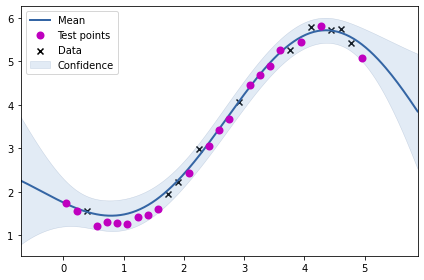

In [45]:
m.plot()
ax = plt.gca()
ax.plot(test_X, test_Y, "mo", mew=2, label="Test points")

ax.legend()

In [46]:
mean_absolute_error(test_Y, m.predict(test_X)[0].flatten())

0.12614127566448338

Above we see the fit for the learnt kernel parameters.

### Other kernels

We have thus far discussed RBF kernel. Let us now have a quick look at Periodic kernel before we look at combining different kernel.

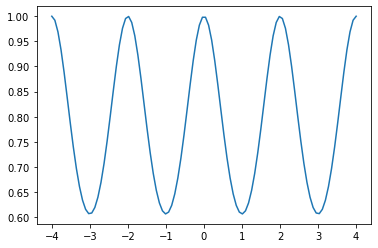

In [48]:
k = GPy.kern.StdPeriodic(1, period=2)
data = np.linspace(-4.,4.,100)[:, None]
C = k.K(data, np.array([[0.]]))

plt.plot(data,C)

The periodic kernel does what you might expect -- there is a periodic nature of realtion between different points.

Let us now try to fit the periodic kernel to our previously geenrated data.

In [49]:
m = GPy.models.GPRegression(train_X, train_Y, k)
m.optimize()

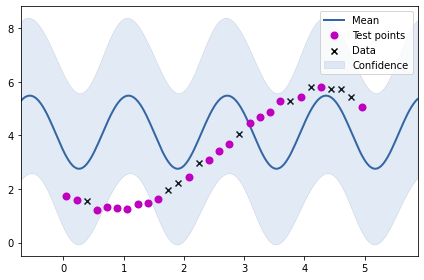

In [53]:
m.plot()
ax = plt.gca()
ax.plot(test_X, test_Y, "mo", mew=2, label='Test points')

ax.legend()

As we might have expected, the fit is not very good. Let us create a data set having periodicity where out kernel would be better

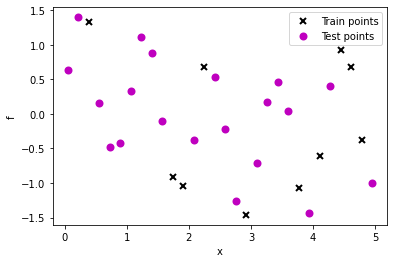

In [56]:
# lambda function, call f(x) to generate data
g = lambda x: np.sin(6*x) + 0.5*np.cos(x)

np.random.seed(0)
# 30 equally spaced sample locations
X2 = np.linspace(0.05, 4.95, 30)[:,None]

np.random.shuffle(X2)

# y = f(X) + epsilon
Y2 = g(X2) + np.random.normal(0., 0.1, (30,1)) # note that np.random.normal takes mean and s.d.

train_X2 = X2[:10]
train_Y2 = Y2[:10]

test_X2 = X2[10:]
test_Y2 = Y2[10:]

# Plot observations
plt.plot(train_X2, train_Y2, "kx", mew=2, label='Train points')
plt.plot(test_X2, test_Y2, "mo", mew=2, label='Test points')

# Annotate plot
plt.xlabel("x"), plt.ylabel("f")
plt.legend()

In [60]:
m = GPy.models.GPRegression(train_X2, train_Y2, k)
m.optimize()

In [61]:
m

GP_regression.,value,constraints,priors
std_periodic.variance,1.6241632832627175,+ve,
std_periodic.period,2.049817473502324,+ve,
std_periodic.lengthscale,0.5405891275623953,+ve,
Gaussian_noise.variance,0.026138552545208665,+ve,


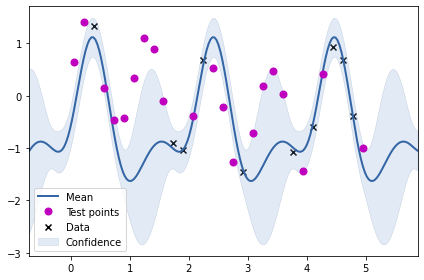

In [62]:
m.plot()
ax = plt.gca()
ax.plot(test_X2, test_Y2, "mo", mew=2, label='Test points')

ax.legend()

From the plot above, we can see that just using the periodic kernel is not very useful. Maybe we need to combine the RBF kernel and periodic kernel. WE will be trying two combinations: adding the two kernels and multiplying the two kernels to obtain two new kernels.

In [63]:
k1 = GPy.kern.StdPeriodic(1, period=2)
k2 = GPy.kern.RBF(1, lengthscale=1)
k_combined_1 = k1+k2
k_combined_2 = k1*k2

Let us now try to visualize the two kernels

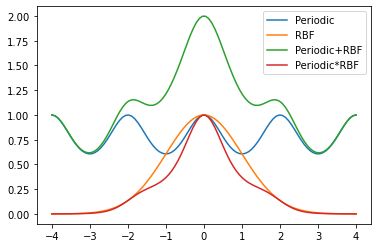

In [66]:
C1 = k_combined_1.K(data, np.array([[0.]]))
C2 = k_combined_2.K(data, np.array([[0.]]))

plt.plot(data, k1.K(data, np.array([[0.]])), label="Periodic")
plt.plot(data, k2.K(data, np.array([[0.]])), label="RBF")

plt.plot(data, C1, label="Periodic+RBF")
plt.plot(data, C2, label="Periodic*RBF")
plt.legend()
pass

We can also visualize the covariance matrices corresponding to the two new kernels we have created.

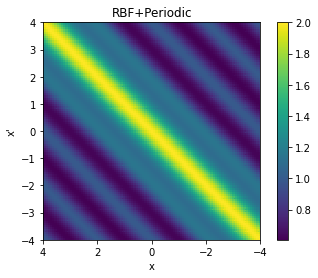

In [67]:
cov = k_combined_1.K(data,data)

# Plot the covariance of the sample space
plt.pcolor(data.T, data, cov)

# Format and annotate plot
plt.gca().invert_xaxis(), plt.gca().axis("image")
plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
plt.title("RBF+Periodic");

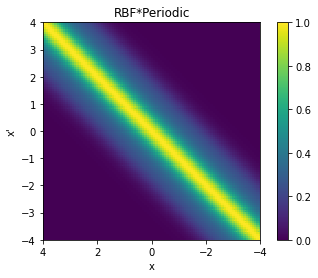

In [68]:
cov = k_combined_2.K(data,data)

# Plot the covariance of the sample space
plt.pcolor(data.T, data, cov)

# Format and annotate plot
plt.gca().invert_xaxis(), plt.gca().axis("image")
plt.xlabel("x"), plt.ylabel("x'"), plt.colorbar()
plt.title("RBF*Periodic");

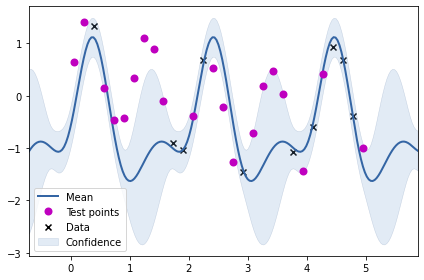

In [71]:
m = GPy.models.GPRegression(train_X2, train_Y2, k_combined_1)
m.optimize()
m.plot()
ax = plt.gca()
ax.plot(test_X2, test_Y2, "mo", mew=2, label='Test points')

ax.legend()


Name : GP regression
Objective : 13.80672630583814
Number of Parameters : 6
Number of Optimization Parameters : 6
Updates : True
Parameters:
  GP_regression.                |                  value  |  constraints  |  priors
  mul.std_periodic.variance     |  0.0016702091497415362  |      +ve      |        
  mul.std_periodic.period       |     5.0069673908993675  |      +ve      |        
  mul.std_periodic.lengthscale  |      13.89014252393252  |      +ve      |        
  mul.rbf.variance              |  0.0016702091497477244  |      +ve      |        
  mul.rbf.lengthscale           |     3.1841135629560493  |      +ve      |        
  Gaussian_noise.variance       |     0.9263219627112396  |      +ve      |        


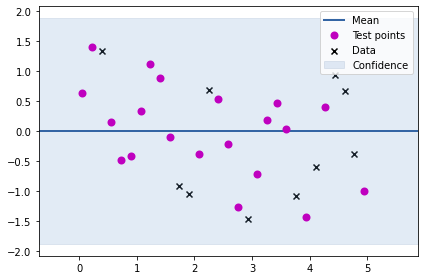

In [73]:
m = GPy.models.GPRegression(train_X2, train_Y2, k_combined_2)
m.optimize()
m.plot()
print(m)
ax = plt.gca()
ax.plot(test_X2, test_Y2, "mo", mew=2, label='Test points')

ax.legend()

From the above two visualisations, we can see the two kernel in actions.

### 2D GP
Having studied GPR for 1 dimensions, we will now be looking at GPR for 2D data. Let us first create some dataset.

In [3]:
X = np.array([[3, 2], [1, 4], [1, 1], [3, 4], [2, 2], [2, 3], [3, 1], [3, 3.5], [2.5, 3.5]])
y = np.array([1, 1, 3, 2, 5.5, 4.5, 0.5, 3, 3.5])

In [4]:
X.shape, y.shape

((9, 2), (9,))

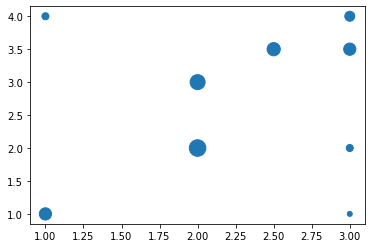

In [7]:
plt.scatter(X[:,0], X[:,1], s=y*50)

The above visualisation shows the dataset where the size of the marker denotes the value at the location. We will now be fitting a GP to this data set.

In [8]:
k_2d = GPy.kern.RBF(input_dim=2, lengthscale=1)

In [9]:
X.shape

(9, 2)

In [11]:
y.reshape(-1,1)

array([[1. ],
       [1. ],
       [3. ],
       [2. ],
       [5.5],
       [4.5],
       [0.5],
       [3. ],
       [3.5]])

In [13]:
m = GPy.models.GPRegression(X, y.reshape(-1, 1), k_2d)
m.optimize()

Generating predictions over the entire grid for visualisation.

In [14]:
x_t = np.linspace(0, 4.5, 40)
y_t = np.linspace(0, 4.5, 40)

XX, YY = np.meshgrid(x_t, y_t)

In [18]:
Z_pred = np.zeros_like(YY)
for i in range(40):
    for j in range(40):
        Z_pred[i, j] = m.predict(np.array([XX[i, j], YY[i, j]]).reshape(1,2))[0]

In [19]:
Z_pred.shape

(40, 40)

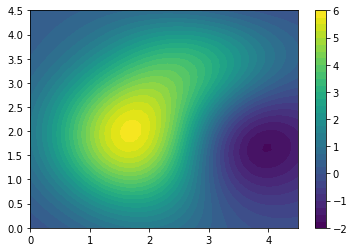

In [25]:
plt.contourf(XX, YY, Z_pred, levels=30)
plt.colorbar()

The above plot shows the prediction in the 2d space. We can alternatively view the 3d surface plot.

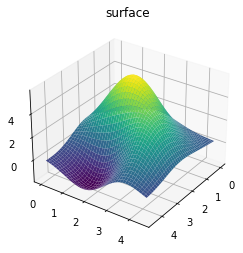

In [28]:
ax = plt.axes(projection='3d')
ax.plot_surface(XX, YY, Z_pred, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_title('surface')
ax.view_init(30, 35)

In [29]:
Z_var = np.zeros_like(YY)
for i in range(40):
    for j in range(40):
        Z_var[i, j] = m.predict(np.array([XX[i, j], YY[i, j]]).reshape(1,2))[1]

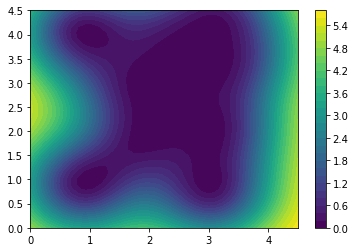

In [30]:
plt.contourf(XX, YY, Z_var, levels=30)
plt.colorbar()

We can above see the variance plot.